In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import warnings
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

warnings.filterwarnings('ignore')


In [3]:

# Define the categories of gestures
CATEGORIES = ["01_palm", '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
IMG_SIZE = 50  # Resize all images to 50x50 pixels for consistency

# Path to the dataset
current_dir = os.getcwd()  # Get the current working directory
data_path = os.path.join(current_dir, 'archive', 'leapGestRecog', 'leapGestRecog')

# Function to load and preprocess images
def load_images(data_path, categories, img_size):
    image_data = []
    total_images = 0
    for dr in os.listdir(data_path):
        for category in categories:
            class_index = categories.index(category)
            path = os.path.join(data_path, dr, category)
            if not os.path.exists(path):
                print(f"Path does not exist: {path}")
                continue
            for img in os.listdir(path):
                try:
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    if img_arr is None:
                        print(f"Failed to load image: {img}")
                        continue
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    image_data.append([resized_arr, class_index])
                    total_images += 1
                except Exception as e:
                    print(f"Error processing image {img}: {e}")
    print(f"Total images loaded: {total_images}")
    return image_data

# Load images
image_data = load_images(data_path, CATEGORIES, IMG_SIZE)

# Optionally, check the shape of the first image
if image_data:
    first_image = image_data[0][0]
    print(f"Shape of the first image: {first_image.shape}")


Total images loaded: 20000
Shape of the first image: (50, 50)


In [4]:
# Shuffle data to ensure randomness
import random
random.shuffle(image_data)

# Split data into input (images) and labels
input_data, labels = zip(*image_data)
input_data = np.array(input_data) / 255.0  # Normalize pixel values to [0, 1]
labels = np.array(labels)

# Convert labels to one-hot encoding
labels = to_categorical(labels)

# Reshape input data to include the channel dimension
input_data = input_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.2, random_state=42)


In [5]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.6645 - loss: 0.9753 - val_accuracy: 0.9977 - val_loss: 0.0177
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9873 - loss: 0.0451 - val_accuracy: 0.9990 - val_loss: 0.0056
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.9934 - loss: 0.0219 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9950 - loss: 0.0161 - val_accuracy: 0.9995 - val_loss: 0.0020
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9959 - loss: 0.0114 - val_accuracy: 0.9995 - val_loss: 0.0023
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9953 - loss: 0.0154 - val_accuracy: 0.9998 - val_loss: 0.0016
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9972 - loss: 0.0099 - val_accuracy: 0.9998 - val_loss: 8.1246e-04
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.9985 - loss: 0.005

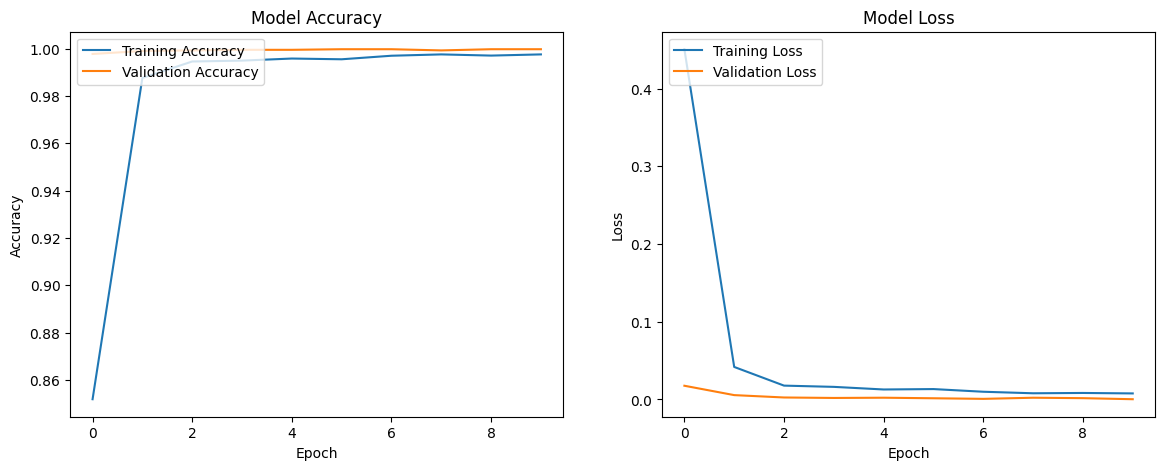

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9998 - loss: 3.6038e-04
Test accuracy: 99.98%


In [6]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2%}')


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


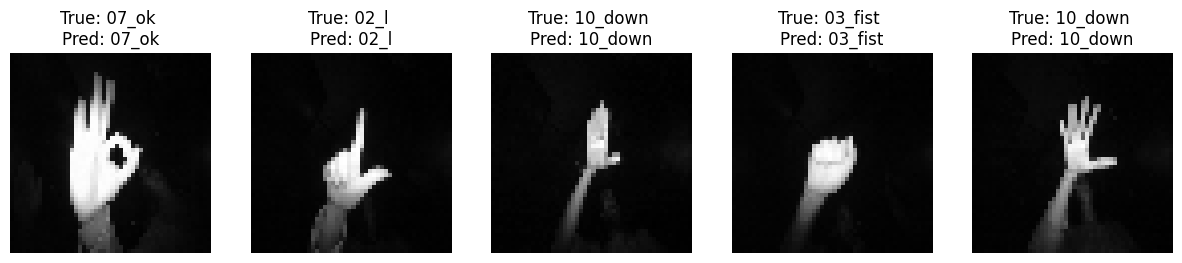

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display test images and their predicted labels
def display_predictions(images, true_labels, predictions, categories, num_images=5):
    # Randomly sample indices
    indices = np.random.choice(len(images), num_images, replace=False)
    
    # Plot settings
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
        plt.imshow(images[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        plt.title(f'True: {categories[np.argmax(true_labels[idx])]} \nPred: {categories[np.argmax(predictions[idx])]}')
        plt.axis('off')
    
    plt.show()

# Make predictions on the test set
predictions = model.predict(X_test)

# Display 10 random test images with their true and predicted labels
display_predictions(X_test, y_test, predictions, CATEGORIES)
